# Практическое ДЗ. Удаление фона с помощью SVD

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.


**Замечание: далее пользоваться циклами запрещено, если это явно не прописано в задании. Вместо этого используйте функции numpy.**

In [73]:
%pip install -q moviepy==1.0.3
%pip install -q ffmpeg

In [74]:
import moviepy.editor as mpe
from google.colab import drive

video = mpe.VideoFileClip("data/SVD_video_1.mp4")
'''
Я запускал так, потому что возникала проблема с запуском по образцу

drive.mount('/content/drive')
video = mpe.VideoFileClip("/content/drive/MyDrive/Colab Notebooks/SVD_video_1.mp4"
)
'''
video.ipython_display(width=300, maxduration=250)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
video.fps

23.976023976023978

In [77]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_w, size_h = video.size
    arr = np.zeros([nframes, size_h, size_w])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 80 x 60, 
number of frames: 2883


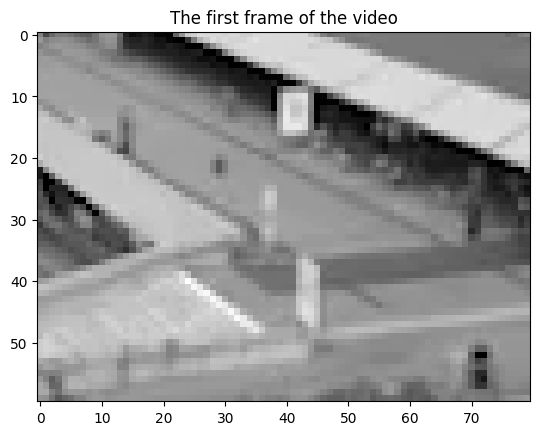

In [78]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

### a. Применение базового алгоритма SVD (30 баллов)

1. **(10 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами. В задании также разрешается использовать транспонирование.

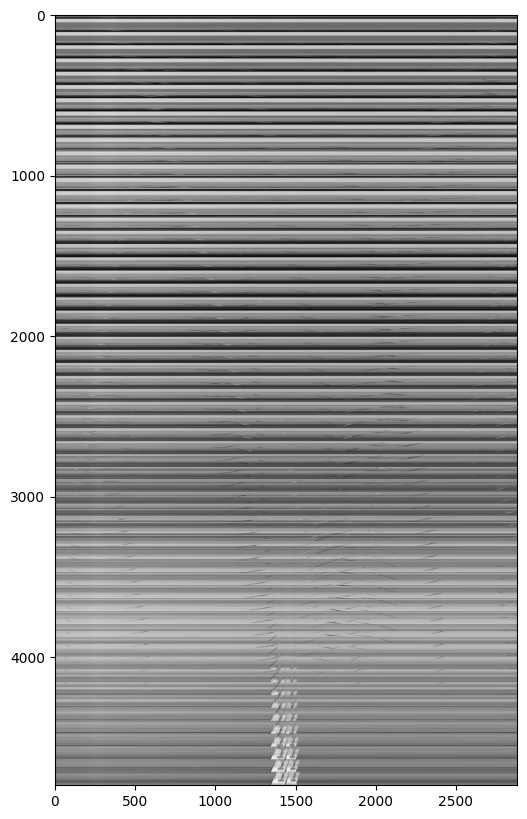

In [79]:
nframes, size_h, size_w = arr.shape
M = arr.reshape(nframes, size_h * size_w).T

plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray');

Если всё сделано правильно, то вы сможете восстановить первый кадр из первого столбца:

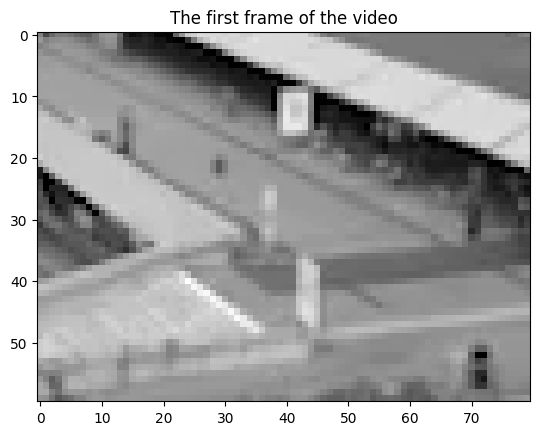

In [80]:
first_frame = M[:,0].reshape(size_h, size_w)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

2. **(6 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных.

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел. Не забывайте подписывать оси!

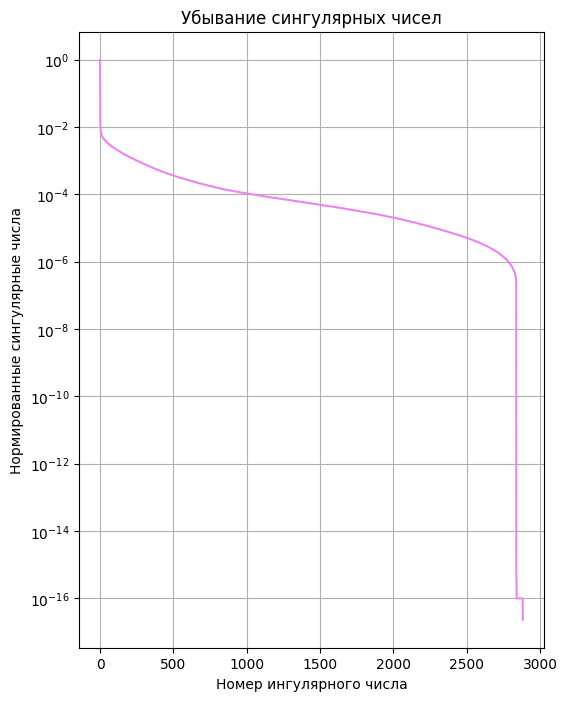

'\nПервое сингулярное число (для видео) отвечает "помещение", всё, что не двигается.\nСингулярные числа, близкие к нулю, отвечают за изменения в видео (кадрах). Это могут быть движения людей, помехи камеры и т.д.\n'

In [81]:
U, S, Vt =np.linalg.svd(M,full_matrices=False)

plt.figure(figsize=(6,8))
plt.semilogy(S /S[0], color="violet")
plt.ylabel("Нормированные сингулярные числа")
plt.xlabel("Номер ингулярного числа")
plt.title("Убывание сингулярных чисел")
plt.grid()
plt.show()

'''
Первое сингулярное число (для видео) отвечает "помещение", всё, что не двигается.
Сингулярные числа, близкие к нулю, отвечают за изменения в видео (кадрах). Это могут быть движения людей, помехи камеры и т.д.
'''

3. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в фробениусовой норме, т.е. $$
\frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$.

In [85]:
def trunc_svd(M, r):
    Ur= U[:,:r]
    Sr = S[:r]
    Vtr = Vt[:r, :]
    # символ @ - перемножение по правилам матриц
    Mr= Ur @ np.diag(Sr)@ Vtr
    rel_eps = np.sqrt(np.sum(S**2) -np.sum(S[0:r]) / np.sum(S**2))
    return Mr, rel_eps

4. **(4 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [86]:
M_svd, rel_error = trunc_svd(M, 1)

first_frame = M[:,0].reshape(size_h, size_w)
first_frame_svd = M_svd[:, 0].reshape(size_h, size_w)
first_frame_people = first_frame -first_frame_svd

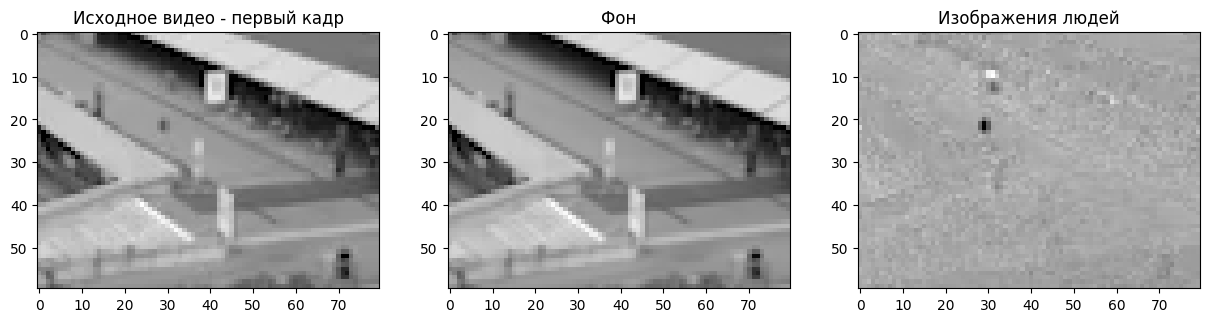

In [87]:
_, axs =plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame,cmap='gray')
axs[0].set_title("Исходное видео - первый кадр")
axs[1].imshow(first_frame_svd, cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow(first_frame_people, cmap='gray')
axs[2].set_title("Изображения людей");

### b. Применение рандомизированного алгоритма SVD (28 баллов)

Загрузим теперь видео в более высоком разрешении.

In [88]:
import moviepy.editor as mpe
from google.colab import drive
drive.mount('/content/drive')

video3 = mpe.VideoFileClip("/content/drive/MyDrive/Colab Notebooks/SVD_video_2.mp4"
)
video3.ipython_display(width=300, maxduration=250)
arr = video_to_array(video3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
image size: 80 x 60, 
number of frames: 2883


In [89]:
arr3 = video_to_array(video3)
nframes, size_h, size_w = arr3.shape
M3 = arr.reshape(nframes,size_h * size_w).T

image size: 80 x 60, 
number of frames: 2883


Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. **(16 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

In [90]:
def rand_svd(M, r,oversampling=10):
  m, n = M.shape
  Omega = np.random.randn(n,r + oversampling)
  Y = M @ Omega
  Q, _= np.linalg.qr(Y)
  B = Q.T@ M
  U_B, S_B, Vt_B = np.linalg.svd(B,full_matrices=False)

  U_r =U_B[:, :r]
  S_r = np.diag(S_B[:r])
  Vt_r = Vt_B[:r, :]

  Mr =Q@ U_r @ S_r@ Vt_r
  rel_eps = np.linalg.norm(M - Mr, 'fro') /np.linalg.norm(M, 'fro')

  return Mr, rel_eps

2. **(2 балл)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [91]:
M_rand, errors = rand_svd(M3, 1)
first_frame = M3[:, 0].reshape(size_h, size_w)
first_frame_rand = M_rand[:, 0].reshape(size_h, size_w)
first_frame_people = first_frame - first_frame_rand


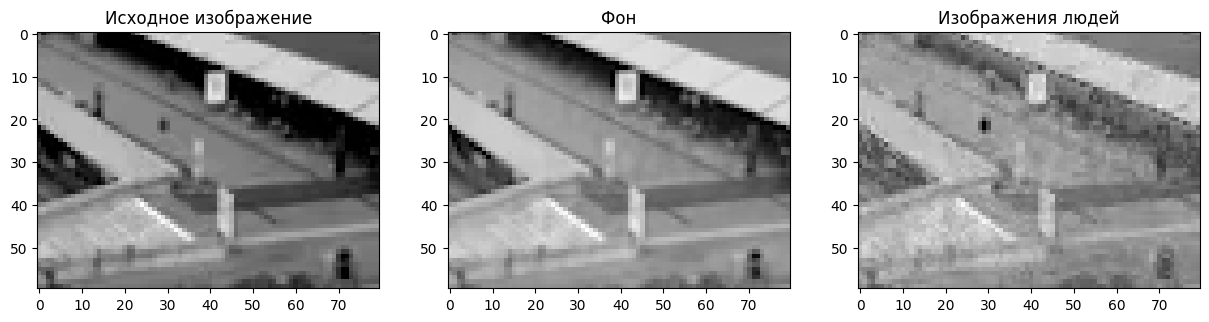

In [92]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame, cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(first_frame_rand, cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow(first_frame_people, cmap='gray')
axs[2].set_title("Изображения людей");

#Из-за того, что ранг приближённой матрицы равен 1, используется лишь 1 сингулярное число, из-за этого выделение людей происходит неэффективно


3. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой.
**В данном задании разрешается использовать циклы для перебора по сетке и запуска алгоритма 10 раз.**

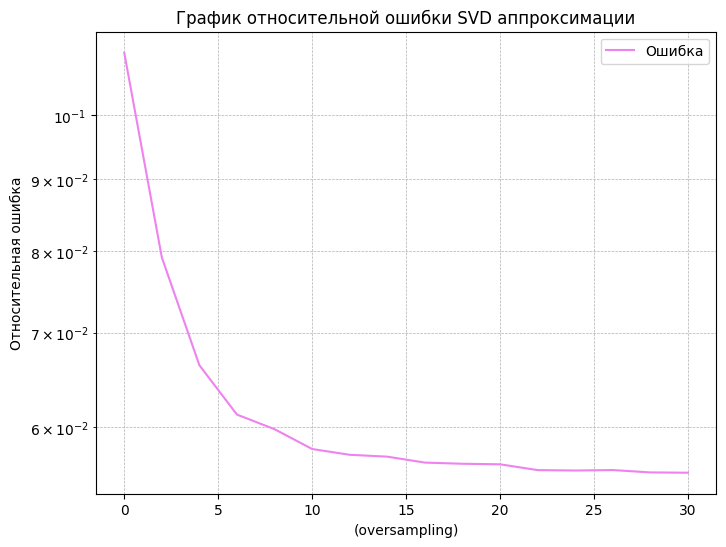

In [93]:
def compute_relative_error(M, r, p, num_trials=10):
    errors = []

    for i in p:
        rel_errors = []
        for _ in range(num_trials):
            M_rand, rel_eps = rand_svd(M, r, i)
            rel_errors.append(rel_eps)

        errors.append(np.mean(rel_errors))

    return errors

p = np.arange(0, 31, 2)
errors = compute_relative_error(M3, r=2, p=p, num_trials=10)

plt.figure(figsize=(8, 6))
plt.plot(p, errors, color='violet', label='Ошибка')
plt.yscale('log')
plt.xlabel('(oversampling)')
plt.ylabel('Относительная ошибка')
plt.title('График относительной ошибки SVD аппроксимации')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм. Также обратите внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может случиться переполнение по памяти.

### c. Видео с переменным освещением (12 баллов)

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [94]:
from google.colab import drive
import moviepy.editor as mpe
'''
Я зкпускал так, потому что возникала проблема с запуском по образцу
drive.mount('/content/drive')

video2 = mpe.VideoFileClip("/content/drive/MyDrive/Colab Notebooks/SVD_video_2.mp4"
)
'''
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")

video2.ipython_display(width=300, maxduration=250)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [95]:
arr2 = video_to_array(video2)

image size: 80 x 60, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [96]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

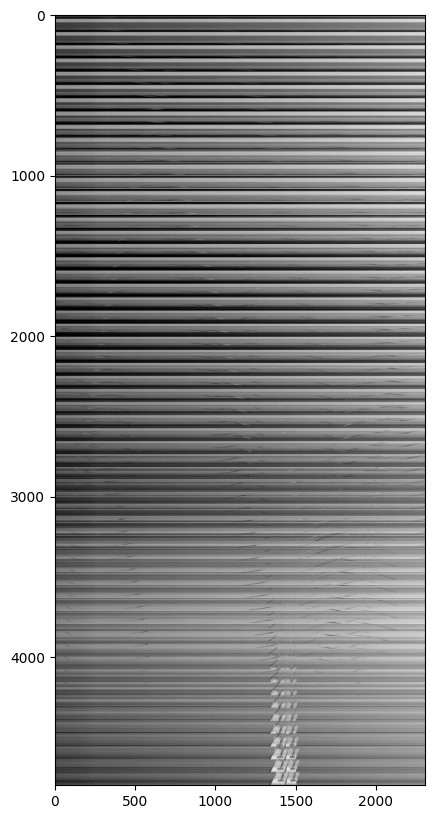

In [97]:
nframes2, size_w, size_h = arr2.shape
M2 = arr2.reshape(nframes2, size_h*size_w).T

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. **(3 балла)** Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравните время работы алгоритмов.

In [98]:
import time
start = time.time()
r = 2

U1, S1, Vt1 = np.linalg.svd(M, full_matrices=False)
time_svd_1 = time.time() - start

Ur1 = U1[:, :r]
Sr1 = S1[:r]
Vtr1 = Vt1[:r, :]
M_rand,_ = rand_svd(M,r)
M1_svd = Ur1 @ np.diag(Sr1) @ Vtr1
rel_error_svd_M = np.linalg.norm(M - M1_svd, ord='fro')/ np.linalg.norm(M, ord='fro')
rel_error_rand = np.linalg.norm(M - M_rand, ord='fro')/ np.linalg.norm(M, ord='fro')

start = time.time()
_, rel_eps_rand_1 = rand_svd(M, r)
time_rand_1 = time.time() - start

start = time.time()
U2, S2, Vt2 = np.linalg.svd(M2, full_matrices=False)
time_svd_2 = time.time() - start

start = time.time()
M2_rand,_ = rand_svd(M2,r)
time_rand_2 = time.time() - start

Ur2 = U2[:, :r]
Sr2 = S2[:r]
Vtr2 = Vt2[:r, :]
M2_rand, rel_error_svd_M2 = rand_svd(M2, r)
M2_svd = Ur2 @ np.diag(Sr2) @ Vtr2
rel_error_rand_M2 = np.linalg.norm(M2 - M2_rand, ord='fro') / np.linalg.norm(M, ord='fro')

print(f"Полное SVD для матрицы M1: {time_svd_1:.4f} сек")
print(f"Рандомизированное SVD для матрицы M1: {time_rand_1:.4f} сек")
print(f"Полное SVD для матрицы M2: {time_svd_2:.4f} сек")
print(f"Рандомизированное SVD для матрицы M2: {time_rand_2:.4f} сек")
print("По результам видно, насколько быстрее работает рандомизированное SVD в сравнении с полным SVD")


Полное SVD для матрицы M1: 61.1242 сек
Рандомизированное SVD для матрицы M1: 0.6477 сек
Полное SVD для матрицы M2: 30.6804 сек
Рандомизированное SVD для матрицы M2: 0.4706 сек
По результам видно, насколько быстрее работает рандомизированное SVD в сравнении с полным SVD


3. **(4 балла)** Cравните относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравните их с соответствующей величиной для видео с постоянным освещением. Какие выводы можно сделать?

In [99]:
print(f"Постоянное освещение (SVD): {rel_error_svd_M:.4f}")
print(f"Постоянное освещение (Rand SVD): {rel_error_rand:.4f}")
print(f"Переменное освещение (SVD): {rel_error_svd_M2:.4f}")
print(f"Переменное освещение (Rand SVD): {rel_error_rand_M2:.4f}")
print("Из результатов видно, что полное SVD дает меньшую относительную ошибку для матрицы M и видео с постоянным освещением по сравнению с рандомизированным SVD, что подтверждает эффективность полного SVD в таких задачах. Рандомизированный SVD показывает чуть большую ошибку, но при этом также предоставляет приемлемые результаты с точки зрения вычислительных затрат.")

Постоянное освещение (SVD): 0.0469
Постоянное освещение (Rand SVD): 0.0524
Переменное освещение (SVD): 0.0651
Переменное освещение (Rand SVD): 0.0547
Из результатов видно, что полное SVD дает меньшую относительную ошибку для матрицы M и видео с постоянным освещением по сравнению с рандомизированным SVD, что подтверждает эффективность полного SVD в таких задачах. Рандомизированный SVD показывает чуть большую ошибку, но при этом также предоставляет приемлемые результаты с точки зрения вычислительных затрат.


4. **(5 балла)** Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [100]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[1]
    arr = M.T.reshape(nframes, size_h, size_w)
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)


Посмотрим, как выглядит предлагаемое приближение.

In [101]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.

### d. Обработка новых кадров (25 баллов)

Предположим, что на камеру поступил новый поток кадров. Мы могли бы увеличить нашу матрицу M2 и пересчитать SVD, но это слишком вычислительно сложно ради нескольких новых кадров. Более того, логично предположить, что если у нас уже было достаточно много кадров в матрице M2, то сингулярные векторы не изменятся сильно от добавления новых кадров.

При этом просто вычесть фон не получится, ведь мы хотим также учитывать изменение освещения. Для этого посчитаем ортогональную проекцию нового кадра на образ матрицы M2.




1. **(15 баллов)** Используя SVD разложение ортогонально спроецируйте новый кадр на образ матрицы M2.

Ваш код должен работать как для 1 кадра (вектора длины size_h * size_w), так и для нескольких (матрицы размера (size_h * size_w) x k). Сложность итогового алгоритма для обработки 1 кадра должна быть O(size_h * size_w). SVD матрицы M2 считайте предпосчитанным.

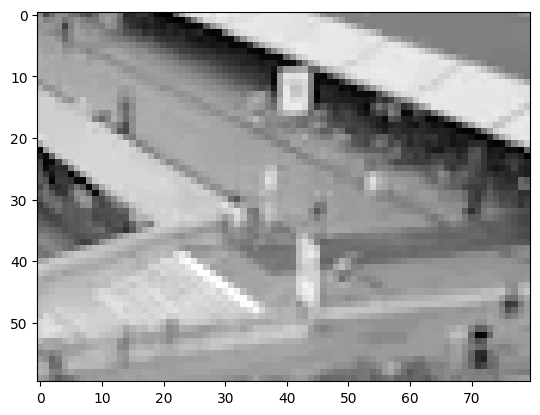

In [102]:
new_frame = remaining[-1].reshape(size_w*size_h)
plt.imshow(new_frame.reshape(size_w, size_h), cmap='gray');

In [103]:
U_2 = Ur2
S_2 = Sr2
VT_2  = Vtr2

In [104]:
def project_new_frames(U, S, VT, new_frames):
    return U @ (U.T @ new_frames)

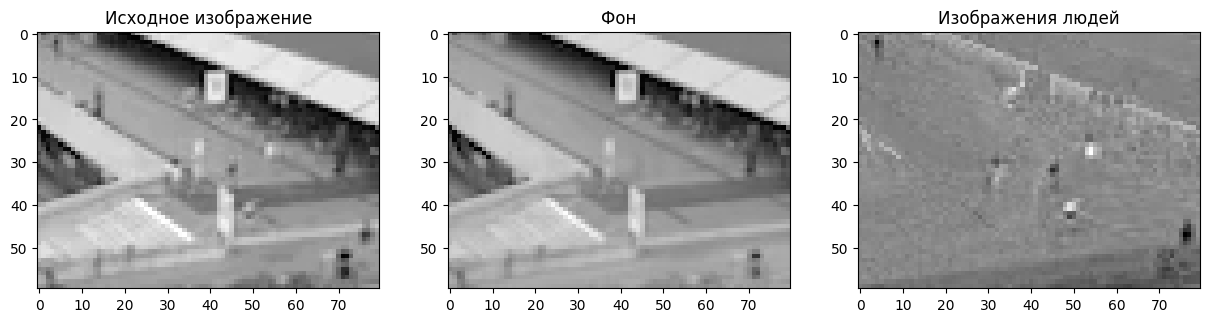

In [105]:
new_frame_proj = project_new_frames(U_2, S_2, VT_2, new_frame)
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(new_frame_proj.reshape(size_w, size_h), cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow((new_frame - new_frame_proj).reshape(size_w, size_h), cmap='gray')
axs[2].set_title("Изображения людей");

2. **(5 баллов)** Используя [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) добавьте кадры из remaining к столбцам M2, чтобы получить матрицу полного видео M_full. Аналогично преобразуйте трехмерный массив remaining в матрицу формате (size_h * size_w x remaining_nframes). Спроецируйте все кадры (столбцы) этой матрицы и преобразуйте матрицу обратно в видео.


In [106]:
remaining_nframes, size_w, size_h = remaining.shape
M_remaining = remaining.reshape(remaining_nframes, size_w * size_h).T
M_full = np.concatenate((M2, M_remaining), axis=1)

In [107]:
M_proj = project_new_frames(U_2, S_2, VT_2, M_full)

video2_svd = M_to_video(M_full - M_proj, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


3. **(2 балла)** Как говорилось выше, можно сэкономить много ресурсов с помощью рандомизированного SVD алгоритма. Рассмотрите аналогичную ортопроекцию с помощью рандомизированного SVD разложения.

In [108]:
r = 2
oversampling = 10

m, n = M2.shape
Omega = np.random.randn(n,r +oversampling)

Y = M2 @Omega
Q, _ =np.linalg.qr(Y)
B = Q.T @ M2
U_B, S_B,Vt_B = np.linalg.svd(B, full_matrices=False)

U_2_rand = Q@ U_B[:, :r]
S_2_rand = np.diag(S_B[:r])
VT_2_rand= Vt_B[:r, :]

In [109]:
remaining_nframes, size_h, size_w =remaining.shape
M_remaining = remaining.reshape(remaining_nframes, size_h * size_w).T
M_full = np.concatenate((M2, M_remaining), axis=1)
M_proj_rand =project_new_frames(U_2_rand, S_2_rand,VT_2_rand, M_full)

video2_svd = M_to_video(M_full -M_proj_rand, 20, size_w, size_h)
video2_svd.ipython_display(width=300,maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


4. **(3 балла)** Найдите $M_{\text{true}}$ - лучшее приближение 2 ранга матрицы M2_full с помощью честного SVD (аналогично заданию c). Посчитайте относительные точности приближений из пунктов 2 и 3; сравните качество видео. Какие выводы можно сделать по качеству видео и итоговым ошибкам?

$$
    \dfrac{\| M_{\text{true}} - M_{\text{proj}} \|_F}{\| M_{\text{true}} \|_{F}};\quad
    \dfrac{\| M_{\text{true}} - M_{\text{proj rand}} \|_F}{\| M_{\text{true}} \|_{F}}
$$

In [110]:
M_true = trunc_svd(M_full,2)[0]

video1_svd = M_to_video(M_full - M_proj, 20, size_w, size_h)
video2_svd = M_to_video(M_full- M_true, 20, size_w, size_h)
video1_svd.ipython_display(width=300, maxduration=250,fps=20)
video2_svd.ipython_display(width=300, maxduration=250,fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [111]:
error_full =np.linalg.norm(M_true- M_proj, 'fro') /np.linalg.norm(M_true, 'fro')
error_rand =np.linalg.norm(M_true- M_proj_rand, 'fro') /np.linalg.norm(M_true, 'fro')

print(f"Относительная ошибка (полный SVD):{error_full:.4f}")
print(f"Относительная ошибка (рандомизированный SVD):{error_rand:.4f}")
print("Заметим, что ошибка (если я правильно сделал) одинаковая, а значит, что рандомизированное SVD даёт наилучшее приближение. Это значит, что матрица малоранговая")

Относительная ошибка (полный SVD):0.2185
Относительная ошибка (рандомизированный SVD):0.2181
Заметим, что ошибка (если я правильно сделал) одинаковая, а значит, что рандомизированное SVD даёт наилучшее приближение. Это значит, что матрица малоранговая


**Выводы:**

### e. Robust PCA (5 баллов)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros).
Однако такую задачу решать крайне сложно из-за отсутствия непрерывности и выпуклости.
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{\mathrm{sum}} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{\mathrm{sum}}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

Для вычисления robust PCA скачаем код по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируем его:

In [ ]:
# Если вы работаете на windows - скачивайте самостоятельно
!wget https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
import r_pca

Мы использовали класс ```R_pca``` и запустили функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$ по матрице $M$ из пункта a).

1. **(5 баллов)** С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео,
    - фона,
    - изображения людей.

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр. Используйте видео с низким разрешением из пункта a).

In [ ]:
Mt = M[:,:M.shape[1]//4:2]
solver = r_pca.R_pca(Mt, mu=0.68) # в нашем случае такой mu работает лучше исходного
L, S = solver.fit(max_iter=4000, iter_print=100)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(..., cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(..., cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(..., cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

Аналогично можно посмотреть на видео движущихся объектов:

In [ ]:
video_rpca = M_to_video(..., 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)